In [12]:
import json
import sympy as sp
x = sp.symbols('x')
sample_file_path = "taylor_dataset_sample.json"

In [4]:
raw_data = json.load(open(sample_file_path))

In [45]:
function_infix = [data["function_infix"] for data in raw_data]
taylor_sympy = [data["taylor_sympy"] for data in raw_data]

res = batch_function_closeness(function_infix, taylor_sympy, x_symbol=x , x_range=(-0.5, 0.5), 
                               num_points=100, mse_threshold=1000.0,
                                 verbose=not True, verbose_warning=True)

In [46]:
raw_data 

[{'function_infix': '-4*x**2',
  'function_prefix': 'mul -2 mul x sub mul 3 x x',
  'taylor_series': '(-4)*x**2',
  'taylor_prefix': 'mul -4 pow x 2',
  'taylor_sympy': '-4*x**2',
  'order': 4,
  'point': 0,
  'num_nodes': 3},
 {'function_infix': 'cos(x)**2',
  'function_prefix': 'pow cos x 2',
  'taylor_series': '1 -x**2 + (1/3)*x**4',
  'taylor_prefix': 'add add 1 mul -1 pow x 2 mul div 1 3 pow x 4',
  'taylor_sympy': 'x**4/3 - x**2 + 1',
  'order': 4,
  'point': 0,
  'num_nodes': 1},
 {'function_infix': 'x*tanh(x)',
  'function_prefix': 'mul x tanh x',
  'taylor_series': 'x**2 + (-1/3)*x**4',
  'taylor_prefix': 'add pow x 2 mul div -1 3 pow x 4',
  'taylor_sympy': '-x**4/3 + x**2',
  'order': 4,
  'point': 0,
  'num_nodes': 3},
 {'function_infix': 'x*tan(x)',
  'function_prefix': 'mul x tan x',
  'taylor_series': 'x**2 + (1/3)*x**4',
  'taylor_prefix': 'add pow x 2 mul div 1 3 pow x 4',
  'taylor_sympy': 'x**4/3 + x**2',
  'order': 4,
  'point': 0,
  'num_nodes': 1},
 {'function_inf

In [ ]:
cnt=0
for data in raw_data:
    function_infix = data["function_infix"]
    taylor_sympy = data["taylor_sympy"]
    
    print(res)
    cnt+=1
    if cnt==4:
        break

Evaluating pair:
  Pred: -4*x**2
  Tgt:  -4*x**2
{'avg_l1': 0.0, 'avg_mse': 0.0, 'avg_rmse': 0.0, 'avg_relative_mse': 0.0}
Evaluating pair:
  Pred: cos(x)**2
  Tgt:  x**4/3 - x**2 + 1
{'avg_l1': 0.006371122763418804, 'avg_mse': 0.0001508775843912726, 'avg_rmse': 0.012283223697029725, 'avg_relative_mse': 0.0002605683513880977}
Evaluating pair:
  Pred: x*tanh(x)
  Tgt:  -x**4/3 + x**2
{'avg_l1': 0.015355339441073113, 'avg_mse': 0.0008384453984568496, 'avg_rmse': 0.02895592164751192, 'avg_relative_mse': 0.0069632026519304765}
Evaluating pair:
  Pred: x*tan(x)
  Tgt:  x**4/3 + x**2
{'avg_l1': 0.030103685650691075, 'avg_mse': 0.0037868743827549674, 'avg_rmse': 0.06153758512287403, 'avg_relative_mse': 0.011739153155759468}


In [23]:
data

{'function_infix': 'x*tan(x)',
 'function_prefix': 'mul x tan x',
 'taylor_series': 'x**2 + (1/3)*x**4',
 'taylor_prefix': 'add pow x 2 mul div 1 3 pow x 4',
 'taylor_sympy': 'x**4/3 + x**2',
 'order': 4,
 'point': 0,
 'num_nodes': 1}

/var/folders/fd/x4jg66r951xfppd52dj608zc0000gn/T/ipykernel_62366/330832609.py:590: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


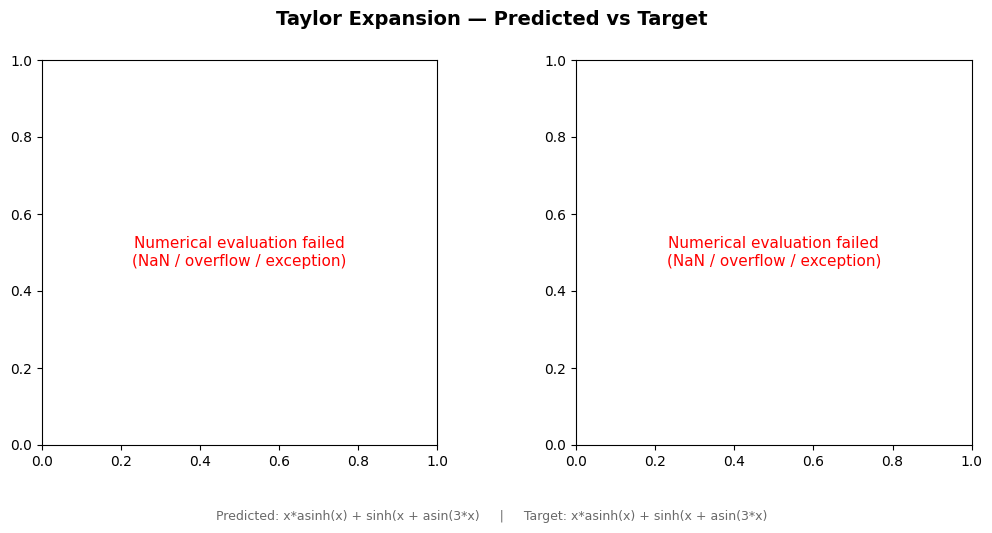

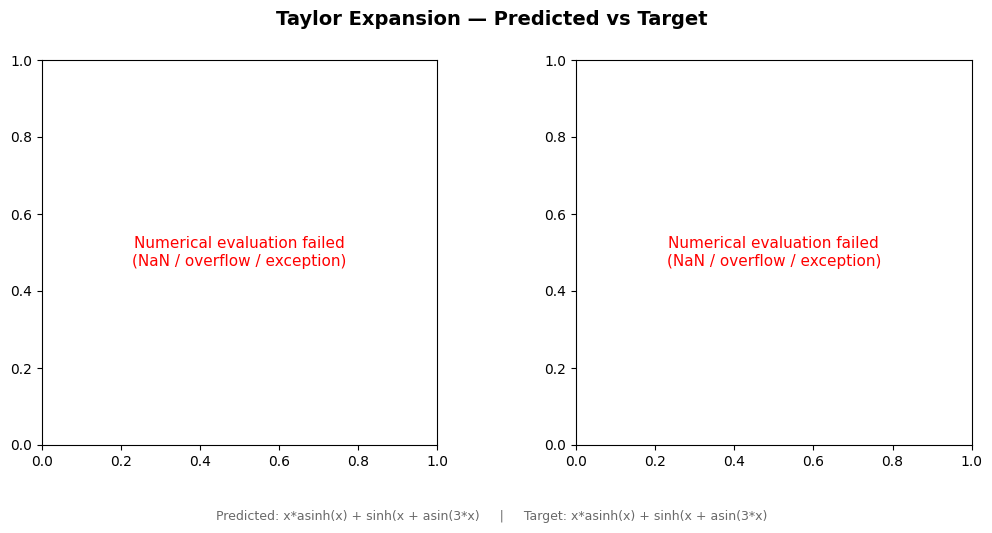

In [23]:
plot_comparison(pred_expr="x*asinh(x) + sinh(x + asin(3*x)", tgt_expr="x*asinh(x) + sinh(x + asin(3*x)", x_symbol=x, x_range=(-0.1, 0.1), num_points=10)

In [1]:
import json
import pickle
from collections import Counter
from typing import List, Tuple, Dict


class WordLevelBPETokenizer:
    """
    BPE applied over whitespace-separated tokens.
    Each space-separated word is treated as one atomic symbol (like a byte).
    Merges combine adjacent words into larger units.
    """

    def __init__(self, num_merges: int = 200):
        self.num_merges = num_merges
        self.merges: List[Tuple[str, str]] = []
        self.vocab: Dict[str, int] = {}
        self.inv_vocab: Dict[int, str] = {}

    # ------------------------------------------------------------
    # Helpers
    # ------------------------------------------------------------
    def _get_stats(self, corpus: List[List[str]]) -> Counter:
        pairs = Counter()
        for token_list in corpus:
            for i in range(len(token_list) - 1):
                pairs[(token_list[i], token_list[i + 1])] += 1
        return pairs

    def _merge_pair(
        self,
        pair: Tuple[str, str],
        corpus: List[List[str]]
    ) -> List[List[str]]:

        merged_corpus = []
        for token_list in corpus:
            i = 0
            new_tokens = []
            while i < len(token_list):
                if (
                    i < len(token_list) - 1
                    and (token_list[i], token_list[i + 1]) == pair
                ):
                    # Merge with a space separator so we can split back later
                    new_tokens.append(pair[0] + " " + pair[1])
                    i += 2
                else:
                    new_tokens.append(token_list[i])
                    i += 1
            merged_corpus.append(new_tokens)

        return merged_corpus

    # ------------------------------------------------------------
    # Train
    # ------------------------------------------------------------
    def fit(self, sequences: List[str]):

        # Each sequence is split by whitespace; each word is one atomic unit
        corpus = []
        for seq in sequences:
            words = seq.split()
            if words:
                corpus.append(words)

        for _ in range(self.num_merges):
            stats = self._get_stats(corpus)
            if not stats:
                break
            best_pair = stats.most_common(1)[0][0]
            self.merges.append(best_pair)
            corpus = self._merge_pair(best_pair, corpus)

        # Build vocab from all unique tokens in the final corpus
        vocab_set = set()
        for token_list in corpus:
            vocab_set.update(token_list)

        # Also include all individual words (the base "bytes") so that
        # unseen sequences can still be encoded word-by-word
        for seq in sequences:
            for w in seq.split():
                vocab_set.add(w)

        vocab_list = sorted(vocab_set)
        self.vocab = {tok: idx for idx, tok in enumerate(vocab_list)}
        self.inv_vocab = {idx: tok for tok, idx in self.vocab.items()}

    # ------------------------------------------------------------
    # Encode
    # ------------------------------------------------------------
    def encode(self, sequence: str) -> List[int]:

        token_list = sequence.split()

        for pair in self.merges:
            i = 0
            new_tokens = []
            while i < len(token_list):
                if (
                    i < len(token_list) - 1
                    and (token_list[i], token_list[i + 1]) == pair
                ):
                    new_tokens.append(pair[0] + " " + pair[1])
                    i += 2
                else:
                    new_tokens.append(token_list[i])
                    i += 1
            token_list = new_tokens

        return [self.vocab[t] for t in token_list if t in self.vocab]

    # ------------------------------------------------------------
    # Decode
    # ------------------------------------------------------------
    def decode(self, ids: List[int]) -> str:
        tokens = [self.inv_vocab[i] for i in ids]
        # Each token may be a merged multi-word string (space-separated)
        # Join tokens with spaces to reconstruct the sequence
        return " ".join(tokens)

    # ------------------------------------------------------------
    # Save / Load
    # ------------------------------------------------------------
    def save(self, path: str):
        with open(path, "wb") as f:
            pickle.dump(
                {"merges": self.merges, "vocab": self.vocab},
                f
            )

    def load(self, path: str):
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.merges = data["merges"]
        self.vocab = data["vocab"]
        self.inv_vocab = {v: k for k, v in self.vocab.items()}


# ------------------------------------------------------------------
# Wrapper: Two Separate Vocabularies
# ------------------------------------------------------------------

class DualBPETokenizer:
    def __init__(self, num_merges: int = 200):
        self.input_tokenizer = WordLevelBPETokenizer(num_merges)
        self.output_tokenizer = WordLevelBPETokenizer(num_merges)

    def fit(self, json_path: str):

        raw_data = json.load(open(json_path))

        input_sequences = []
        output_sequences = []

        for item in raw_data:
            input_sequences.append(item["function_prefix"])
            output_sequences.append(item["taylor_prefix"])

        self.input_tokenizer.fit(input_sequences)
        self.output_tokenizer.fit(output_sequences)

    def encode_input(self, seq: str) -> List[int]:
        return self.input_tokenizer.encode(seq)

    def encode_output(self, seq: str) -> List[int]:
        return self.output_tokenizer.encode(seq)

    def decode_input(self, ids: List[int]) -> str:
        return self.input_tokenizer.decode(ids)

    def decode_output(self, ids: List[int]) -> str:
        return self.output_tokenizer.decode(ids)

    def save(self, path: str):
        with open(path, "wb") as f:
            pickle.dump(
                {
                    "input_merges": self.input_tokenizer.merges,
                    "input_vocab": self.input_tokenizer.vocab,
                    "output_merges": self.output_tokenizer.merges,
                    "output_vocab": self.output_tokenizer.vocab,
                },
                f
            )

    def load(self, path: str):
        with open(path, "rb") as f:
            data = pickle.load(f)

        self.input_tokenizer.merges = data["input_merges"]
        self.input_tokenizer.vocab = data["input_vocab"]
        self.input_tokenizer.inv_vocab = {
            v: k for k, v in data["input_vocab"].items()
        }

        self.output_tokenizer.merges = data["output_merges"]
        self.output_tokenizer.vocab = data["output_vocab"]
        self.output_tokenizer.inv_vocab = {
            v: k for k, v in data["output_vocab"].items()
        }

In [2]:
from collections import Counter

def check_token_coverage(tokenizer_part, sequences):
    counts = Counter()
    for seq in sequences:
        ids = tokenizer_part.encode(seq)
        counts.update(ids)
    
    total = len(counts)
    rare = sum(1 for c in counts.values() if c < 5)
    print(f"  Vocab used: {total}, rare tokens (<5 occurrences): {rare} ({100*rare/total:.0f}%)")

# Run for each merge level
import json
from collections import Counter


def check_token_coverage(tokenizer_part, sequences):
    counts = Counter()
    for seq in sequences:
        ids = tokenizer_part.encode(seq)
        counts.update(ids)

    total = len(counts)
    rare = sum(1 for c in counts.values() if c < 5)
    print(f"  Vocab used: {total}, rare tokens (<5 occurrences): {rare} ({100*rare/total:.0f}%)")


def avg_seq_length(tokenizer_part, sequences):
    lengths = [len(tokenizer_part.encode(s)) for s in sequences]
    print(f"  Avg length: {sum(lengths)/len(lengths):.1f}, Max: {max(lengths)}")


json_path = "taylor_dataset_sample.json"
raw_data = json.load(open(json_path))

input_sequences = [item["function_prefix"] for item in raw_data]
output_sequences = [item["taylor_prefix"] for item in raw_data]

print(f"Dataset size: {len(raw_data)} samples")
print(f"{'='*80}")

for num_merges in [0, 10, 25, 50, 100, 200, 500, 1000]:
    tokenizer = DualBPETokenizer(num_merges=num_merges)
    tokenizer.fit(json_path)

    input_vocab = len(tokenizer.input_tokenizer.vocab)
    output_vocab = len(tokenizer.output_tokenizer.vocab)

    print(f"\nnum_merges={num_merges}, input_vocab_size={input_vocab}, output_vocab_size={output_vocab}")

    print("  [Input]")
    check_token_coverage(tokenizer.input_tokenizer, input_sequences)
    avg_seq_length(tokenizer.input_tokenizer, input_sequences)

    print("  [Output]")
    check_token_coverage(tokenizer.output_tokenizer, output_sequences)
    avg_seq_length(tokenizer.output_tokenizer, output_sequences)

    print(f"  {'-'*60}")

Dataset size: 1000 samples

num_merges=0, input_vocab_size=28, output_vocab_size=153
  [Input]
  Vocab used: 28, rare tokens (<5 occurrences): 0 (0%)
  Avg length: 9.9, Max: 43
  [Output]
  Vocab used: 153, rare tokens (<5 occurrences): 107 (70%)
  Avg length: 13.3, Max: 31
  ------------------------------------------------------------

num_merges=10, input_vocab_size=38, output_vocab_size=162
  [Input]
  Vocab used: 38, rare tokens (<5 occurrences): 0 (0%)
  Avg length: 7.9, Max: 39
  [Output]
  Vocab used: 161, rare tokens (<5 occurrences): 107 (66%)
  Avg length: 7.6, Max: 19
  ------------------------------------------------------------

num_merges=25, input_vocab_size=53, output_vocab_size=177
  [Input]
  Vocab used: 53, rare tokens (<5 occurrences): 0 (0%)
  Avg length: 6.9, Max: 33
  [Output]
  Vocab used: 176, rare tokens (<5 occurrences): 108 (61%)
  Avg length: 6.0, Max: 16
  ------------------------------------------------------------

num_merges=50, input_vocab_size=78, out

In [2]:
from typing import List, Tuple

import torch
import torch.nn as nn


# ---------------------------------------------------------------------------
# Encoder
# ---------------------------------------------------------------------------

class Encoder(nn.Module):
    def __init__(
        self,
        input_vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int,
        dropout: float,
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(
        self, src: torch.Tensor
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # src: (B, src_len)
        embedded = self.dropout(self.embedding(src))          # (B, src_len, emb_dim)
        _, (hidden, cell) = self.lstm(embedded)               # hidden/cell: (num_layers, B, H)
        return hidden, cell


# ---------------------------------------------------------------------------
# Decoder (single step)
# ---------------------------------------------------------------------------

class Decoder(nn.Module):
    def __init__(
        self,
        output_vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int,
        dropout: float,
    ):
        super().__init__()
        self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        token: torch.Tensor,
        hidden: torch.Tensor,
        cell: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # token: (B,)  →  unsqueeze to (B, 1) for batch_first LSTM
        token = token.unsqueeze(1)                            # (B, 1)
        embedded = self.dropout(self.embedding(token))        # (B, 1, emb_dim)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output: (B, 1, H)
        logits = self.fc_out(output.squeeze(1))               # (B, output_vocab_size)
        return logits, hidden, cell


# ---------------------------------------------------------------------------
# Seq2Seq model
# ---------------------------------------------------------------------------

class Seq2SeqLSTM(nn.Module):
    def __init__(
        self,
        input_vocab_size: int,
        output_vocab_size: int,
        embedding_dim: int = 256,
        hidden_dim: int = 512,
        num_layers: int = 2,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.encoder = Encoder(
            input_vocab_size, embedding_dim, hidden_dim, num_layers, dropout
        )
        self.decoder = Decoder(
            output_vocab_size, embedding_dim, hidden_dim, num_layers, dropout
        )

    # -----------------------------------------------------------------------
    # forward — teacher-forced training pass
    # -----------------------------------------------------------------------
    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """
        Args:
            src : (B, src_len)   — source token IDs
            tgt : (B, tgt_len)   — target token IDs (including <SOS> prefix)

        Returns:
            logits : (B, tgt_len - 1, output_vocab_size)
                     Predictions for positions 1 … tgt_len-1
                     (i.e. we predict the next token at every step).
        """
        _, tgt_len = tgt.shape

        hidden, cell = self.encoder(src)

        # Teacher forcing: feed tgt[:, t] to predict tgt[:, t+1]
        all_logits = []
        for t in range(tgt_len - 1):
            logits, hidden, cell = self.decoder(tgt[:, t], hidden, cell)
            all_logits.append(logits.unsqueeze(1))             # (B, 1, V_out)

        return torch.cat(all_logits, dim=1)                    # (B, tgt_len-1, V_out)

    # -----------------------------------------------------------------------
    # generate — autoregressive inference (greedy or beam search)
    # -----------------------------------------------------------------------
    @torch.no_grad()
    def generate(
        self,
        src: torch.Tensor,
        tokenizer,                 # DualBPETokenizer
        max_len: int = 128,
        beam_width: int = 1,
    ) -> Tuple[List[int], str]:
        """
        Args:
            src        : (1, src_len)  — single source sequence (batch size 1)
            tokenizer  : DualBPETokenizer whose output_tokenizer must have
                         '<SOS>' and '<EOS>' in its vocab.
            max_len    : maximum number of tokens to generate
            beam_width : 1 → greedy decoding, >1 → beam search

        Returns:
            (token_ids, decoded_string)
        """
        out_tok = tokenizer.output_tokenizer
        sos_id = out_tok.vocab["<SOS>"]
        eos_id = out_tok.vocab["<EOS>"]

        hidden, cell = self.encoder(src)

        if beam_width <= 1:
            return self._greedy(hidden, cell, sos_id, eos_id, max_len, out_tok)
        else:
            return self._beam_search(
                hidden, cell, sos_id, eos_id, max_len, beam_width, out_tok
            )

    # -----------------------------------------------------------------------
    # Greedy decoding
    # -----------------------------------------------------------------------
    def _greedy(
        self,
        hidden: torch.Tensor,
        cell: torch.Tensor,
        sos_id: int,
        eos_id: int,
        max_len: int,
        tokenizer,
    ) -> Tuple[List[int], str]:
        device = hidden.device
        token = torch.tensor([sos_id], device=device)        # (1,)
        generated: List[int] = []

        for _ in range(max_len):
            logits, hidden, cell = self.decoder(token, hidden, cell)
            next_id = logits.argmax(dim=-1).item()
            if next_id == eos_id:
                break
            generated.append(next_id)
            token = torch.tensor([next_id], device=device)

        decoded = tokenizer.decode(generated)
        return generated, decoded

    # -----------------------------------------------------------------------
    # Beam search decoding
    # -----------------------------------------------------------------------
    def _beam_search(
        self,
        hidden: torch.Tensor,
        cell: torch.Tensor,
        sos_id: int,
        eos_id: int,
        max_len: int,
        beam_width: int,
        tokenizer,
    ) -> Tuple[List[int], str]:
        """
        Beam state: (neg_log_prob, token_ids, hidden, cell)
        We use neg_log_prob so Python's min-heap gives best (lowest neg) first.
        """
        device = hidden.device

        # Initial beam: single hypothesis starting with <SOS>
        init_token = torch.tensor([sos_id], device=device)
        logits, h0, c0 = self.decoder(init_token, hidden, cell)
        log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)  # (V_out,)

        # Seed the beam with top-k tokens
        topk_log_probs, topk_ids = log_probs.topk(beam_width)
        # heap entry: (-score, token_list, hidden, cell)
        beam = []
        for lp, tid in zip(topk_log_probs.tolist(), topk_ids.tolist()):
            beam.append((-lp, [tid], h0, c0))

        completed: List[Tuple[float, List[int]]] = []

        for _ in range(max_len - 1):
            candidates = []
            for neg_score, ids, h, c in beam:
                last_id = ids[-1]
                if last_id == eos_id:
                    completed.append((neg_score, ids[:-1]))  # drop <EOS> from output
                    continue

                token = torch.tensor([last_id], device=device)
                logits, h_new, c_new = self.decoder(token, h, c)
                log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)

                topk_log_probs, topk_ids = log_probs.topk(beam_width)
                for lp, tid in zip(topk_log_probs.tolist(), topk_ids.tolist()):
                    new_score = neg_score - lp          # accumulate neg log probs
                    candidates.append((new_score, ids + [tid], h_new, c_new))

            if not candidates:
                break

            # Keep top beam_width candidates
            candidates.sort(key=lambda x: x[0])
            beam = candidates[:beam_width]

        # Collect any unfinished hypotheses
        for neg_score, ids, _, _ in beam:
            last = ids[-1] if ids else eos_id
            if last == eos_id:
                completed.append((neg_score, ids[:-1]))
            else:
                completed.append((neg_score, ids))

        if not completed:
            completed = [(neg_score, ids) for neg_score, ids, _, _ in beam]

        # Best hypothesis = lowest neg log prob (highest log prob)
        _, best_ids = min(completed, key=lambda x: x[0])
        decoded = tokenizer.decode(best_ids)
        return best_ids, decoded




In [5]:
import sys
sys.path.insert(0, ".")
from tokenizer import DualBPETokenizer

# --- Build a tiny dual tokenizer with special tokens ---
dual_tok = DualBPETokenizer(num_merges=10)

dual_tok.fit("taylor_dataset_sample.json")
# Inject special tokens into output tokenizer
# (in real training, prepend them to sequences before calling fit)
for special in ["<PAD>", "<SOS>", "<EOS>"]:
    if special not in dual_tok.output_tokenizer.vocab:
        new_id = len(dual_tok.output_tokenizer.vocab)
        dual_tok.output_tokenizer.vocab[special] = new_id
        dual_tok.output_tokenizer.inv_vocab[new_id] = special

INPUT_VOCAB  = len(dual_tok.input_tokenizer.vocab)
OUTPUT_VOCAB = len(dual_tok.output_tokenizer.vocab)

print(f"input  vocab size : {INPUT_VOCAB}")
print(f"output vocab size : {OUTPUT_VOCAB}")

input  vocab size : 38
output vocab size : 165


In [ ]:

model = Seq2SeqLSTM(
    input_vocab_size=INPUT_VOCAB,
    output_vocab_size=OUTPUT_VOCAB,
    embedding_dim=32,
    hidden_dim=64,
    num_layers=2,
    dropout=0.1,
)
model.eval()

BATCH, SRC_LEN, TGT_LEN = 4, 10, 12

src = torch.randint(0, INPUT_VOCAB,  (BATCH, SRC_LEN))
tgt = torch.randint(0, OUTPUT_VOCAB, (BATCH, TGT_LEN))

# --- Forward pass ---
logits = model(src, tgt)
print(f"forward  logits shape : {logits.shape}")
assert logits.shape == (BATCH, TGT_LEN - 1, OUTPUT_VOCAB)

In [7]:
res = model.forward(src, tgt)
print(res.shape)

torch.Size([4, 11, 165])


In [ ]:



# --- Greedy generate (pass full DualBPETokenizer) ---
src_single = src[:1]
ids_greedy, text_greedy = model.generate(
    src_single, dual_tok, max_len=20, beam_width=1
)
print(f"greedy   token ids    : {ids_greedy}")
print(f"greedy   decoded      : {text_greedy!r}")

# --- Beam search generate ---
ids_beam, text_beam = model.generate(
    src_single, dual_tok, max_len=20, beam_width=3
)
print(f"beam(3)  token ids    : {ids_beam}")
print(f"beam(3)  decoded      : {text_beam!r}")

print("\nAll checks passed.")


input  vocab size : 38
output vocab size : 165
forward  logits shape : torch.Size([4, 11, 165])
greedy   token ids    : [142, 142, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
greedy   decoded      : '766987 766987 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8'
beam(3)  token ids    : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]
beam(3)  decoded      : '-8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8 -8'

All checks passed.


In [8]:
import json
import os
import pickle
from collections import Counter
from typing import Dict, List, Tuple

import torch
from torch.utils.data import DataLoader, Dataset


# ---------------------------------------------------------------------------
# Special tokens
# ---------------------------------------------------------------------------

PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
UNK = "<UNK>"
SPECIAL_TOKENS = [PAD, SOS, EOS, UNK]


# ---------------------------------------------------------------------------
# Word-Level BPE Tokenizer (special tokens baked into vocab at fixed IDs 0-3)
# ---------------------------------------------------------------------------

class WordLevelBPETokenizer:
    """
    BPE applied over whitespace-separated tokens.
    Special tokens (PAD, SOS, EOS, UNK) are always reserved at IDs 0-3.
    All BPE-derived vocab entries are assigned IDs starting from 4.
    """

    def __init__(self, num_merges: int = 200):
        self.num_merges = num_merges
        self.merges: List[Tuple[str, str]] = []
        self.vocab: Dict[str, int] = {}
        self.inv_vocab: Dict[int, str] = {}

    # -- Special token ID properties --
    @property
    def pad_id(self) -> int:
        return self.vocab[PAD]

    @property
    def sos_id(self) -> int:
        return self.vocab[SOS]

    @property
    def eos_id(self) -> int:
        return self.vocab[EOS]

    @property
    def unk_id(self) -> int:
        return self.vocab[UNK]

    # -- BPE helpers --
    def _get_stats(self, corpus: List[List[str]]) -> Counter:
        pairs: Counter = Counter()
        for token_list in corpus:
            for i in range(len(token_list) - 1):
                pairs[(token_list[i], token_list[i + 1])] += 1
        return pairs

    def _merge_pair(
        self,
        pair: Tuple[str, str],
        corpus: List[List[str]],
    ) -> List[List[str]]:
        merged_corpus = []
        for token_list in corpus:
            i, new_tokens = 0, []
            while i < len(token_list):
                if (
                    i < len(token_list) - 1
                    and (token_list[i], token_list[i + 1]) == pair
                ):
                    new_tokens.append(pair[0] + " " + pair[1])
                    i += 2
                else:
                    new_tokens.append(token_list[i])
                    i += 1
            merged_corpus.append(new_tokens)
        return merged_corpus

    # -- Fit --
    def fit(self, sequences: List[str]):
        corpus = [s.split() for s in sequences if s.split()]

        for _ in range(self.num_merges):
            stats = self._get_stats(corpus)
            if not stats:
                break
            best_pair = stats.most_common(1)[0][0]
            self.merges.append(best_pair)
            corpus = self._merge_pair(best_pair, corpus)

        # Collect all BPE tokens plus base words
        vocab_set: set = set()
        for token_list in corpus:
            vocab_set.update(token_list)
        for seq in sequences:
            vocab_set.update(seq.split())

        # IDs 0-3 are reserved for special tokens; BPE vocab starts at 4
        self.vocab = {tok: idx for idx, tok in enumerate(SPECIAL_TOKENS)}
        for tok in sorted(vocab_set):
            if tok not in self.vocab:          # don't overwrite special tokens
                self.vocab[tok] = len(self.vocab)
        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    # -- Encode --
    def encode(self, sequence: str) -> List[int]:
        token_list = sequence.split()
        for pair in self.merges:
            i, new_tokens = 0, []
            while i < len(token_list):
                if (
                    i < len(token_list) - 1
                    and (token_list[i], token_list[i + 1]) == pair
                ):
                    new_tokens.append(pair[0] + " " + pair[1])
                    i += 2
                else:
                    new_tokens.append(token_list[i])
                    i += 1
            token_list = new_tokens
        return [self.vocab.get(t, self.vocab[UNK]) for t in token_list]

    # -- Decode (strips PAD / SOS / EOS automatically) --
    def decode(self, ids: List[int]) -> str:
        skip = {self.pad_id, self.sos_id, self.eos_id}
        tokens = [self.inv_vocab.get(i, UNK) for i in ids if i not in skip]
        return " ".join(tokens)

    def __len__(self) -> int:
        return len(self.vocab)

    # -- Save / Load --
    def save(self, path: str):
        with open(path, "wb") as f:
            pickle.dump({"merges": self.merges, "vocab": self.vocab}, f)

    def load(self, path: str):
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.merges = data["merges"]
        self.vocab = data["vocab"]
        self.inv_vocab = {v: k for k, v in self.vocab.items()}


# ---------------------------------------------------------------------------
# Dual BPE Tokenizer — one tokenizer per side (input / output)
# ---------------------------------------------------------------------------

class DualBPETokenizer:
    """Wraps two independent WordLevelBPETokenizers, one per modality."""

    def __init__(self, num_merges: int = 200):
        self.input_tokenizer  = WordLevelBPETokenizer(num_merges)
        self.output_tokenizer = WordLevelBPETokenizer(num_merges)

    # -- Fit both sides from a JSON file --
    def fit(self, json_path: str):
        with open(json_path) as f:
            raw_data = json.load(f)
        input_seqs  = [item["function_prefix"] for item in raw_data]
        output_seqs = [item["taylor_prefix"]   for item in raw_data]
        self.input_tokenizer.fit(input_seqs)
        self.output_tokenizer.fit(output_seqs)

    # -- Encode / Decode convenience wrappers --
    def encode_input(self, seq: str) -> List[int]:
        return self.input_tokenizer.encode(seq)

    def encode_output(self, seq: str) -> List[int]:
        return self.output_tokenizer.encode(seq)

    def decode_input(self, ids: List[int]) -> str:
        return self.input_tokenizer.decode(ids)

    def decode_output(self, ids: List[int]) -> str:
        return self.output_tokenizer.decode(ids)

    # -- Vocab size helpers --
    @property
    def input_vocab_size(self) -> int:
        return len(self.input_tokenizer)

    @property
    def output_vocab_size(self) -> int:
        return len(self.output_tokenizer)

    # -- Save / Load --
    def save(self, path: str):
        with open(path, "wb") as f:
            pickle.dump(
                {
                    "input_merges":  self.input_tokenizer.merges,
                    "input_vocab":   self.input_tokenizer.vocab,
                    "output_merges": self.output_tokenizer.merges,
                    "output_vocab":  self.output_tokenizer.vocab,
                },
                f,
            )

    def load(self, path: str):
        with open(path, "rb") as f:
            data = pickle.load(f)
        self.input_tokenizer.merges   = data["input_merges"]
        self.input_tokenizer.vocab    = data["input_vocab"]
        self.input_tokenizer.inv_vocab = {v: k for k, v in data["input_vocab"].items()}
        self.output_tokenizer.merges   = data["output_merges"]
        self.output_tokenizer.vocab    = data["output_vocab"]
        self.output_tokenizer.inv_vocab = {v: k for k, v in data["output_vocab"].items()}


# ---------------------------------------------------------------------------
# Dataset  (tokenizer is injected — no fitting happens here)
# ---------------------------------------------------------------------------

class TaylorDataset(Dataset):
    """
    Reads JSON, encodes sequences with a pre-fitted DualBPETokenizer.
    The tokenizer must already be fitted before passing it in.
    """

    def __init__(self, json_path: str, tokenizer: DualBPETokenizer):
        with open(json_path) as f:
            raw = json.load(f)

        self.tokenizer = tokenizer
        inp_tok = tokenizer.input_tokenizer
        out_tok = tokenizer.output_tokenizer

        # Source: plain encoding
        self.src_ids: List[List[int]] = [
            inp_tok.encode(item["function_prefix"]) for item in raw
        ]
        # Target: wrapped with <SOS> … <EOS>
        self.tgt_ids: List[List[int]] = [
            [out_tok.sos_id]
            + out_tok.encode(item["taylor_prefix"])
            + [out_tok.eos_id]
            for item in raw
        ]

    def __len__(self) -> int:
        return len(self.src_ids)

    def __getitem__(self, idx: int) -> Tuple[List[int], List[int]]:
        return self.src_ids[idx], self.tgt_ids[idx]

    def collate_fn(
        self,
        batch: List[Tuple[List[int], List[int]]],
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        inp_tok = self.tokenizer.input_tokenizer
        out_tok = self.tokenizer.output_tokenizer

        src_batch, tgt_batch = zip(*batch)

        src_lengths = torch.tensor([len(s) for s in src_batch], dtype=torch.long)
        tgt_lengths = torch.tensor([len(t) for t in tgt_batch], dtype=torch.long)

        src_max = int(src_lengths.max())
        tgt_max = int(tgt_lengths.max())
        B = len(src_batch)

        src_tensor = torch.full((B, src_max), inp_tok.pad_id, dtype=torch.long)
        tgt_tensor = torch.full((B, tgt_max), out_tok.pad_id, dtype=torch.long)

        for i, (s, t) in enumerate(zip(src_batch, tgt_batch)):
            src_tensor[i, : len(s)] = torch.tensor(s, dtype=torch.long)
            tgt_tensor[i, : len(t)] = torch.tensor(t, dtype=torch.long)

        return src_tensor, tgt_tensor, src_lengths, tgt_lengths


# ---------------------------------------------------------------------------
# DataLoader helper
# ---------------------------------------------------------------------------

def get_dataloader(
    json_path: str,
    tokenizer: DualBPETokenizer,
    batch_size: int,
    shuffle: bool = True,
) -> Tuple[DataLoader, TaylorDataset]:
    dataset = TaylorDataset(json_path, tokenizer)
    loader  = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=dataset.collate_fn,
    )
    return loader, dataset


# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------




In [28]:
JSON_PATH  = "taylor_dataset_sample.json"
TOK_PATH   = "dual_bpe_tokenizer.pkl"
BATCH_SIZE = 8
NUM_MERGES = 100

# ------------------------------------------------------------------
# 1. Fit tokenizer (or load from disk if already saved)
# ------------------------------------------------------------------
tokenizer = DualBPETokenizer(num_merges=100)

if os.path.exists(TOK_PATH):
    print(f"[tokenizer] Loading from '{TOK_PATH}' ...")
    tokenizer.load(TOK_PATH)
else:
    print(f"[tokenizer] Fitting on '{JSON_PATH}' ...")
    tokenizer.fit(JSON_PATH)
    tokenizer.save(TOK_PATH)
    print(f"[tokenizer] Saved to '{TOK_PATH}'")

print(f"Input  vocab size : {tokenizer.input_vocab_size}")
print(f"Output vocab size : {tokenizer.output_vocab_size}")
print()


[tokenizer] Loading from 'dual_bpe_tokenizer.pkl' ...
Input  vocab size : 32
Output vocab size : 157



In [30]:
# tokenizer.input_tokenizer.vocab, tokenizer.output_tokenizer.vocab

In [31]:
tokenizer.save("bpe_tokenizer.pkl")

In [32]:

# ------------------------------------------------------------------
# 2. Build dataset & dataloader using the fitted tokenizer
# ------------------------------------------------------------------
loader, dataset = get_dataloader(
    JSON_PATH, tokenizer, batch_size=BATCH_SIZE, shuffle=False
)
print(f"Dataset size      : {len(dataset)}")
print()


Dataset size      : 1000



In [33]:

# ------------------------------------------------------------------
# 3. Inspect first batch
# ------------------------------------------------------------------
src, tgt, src_lens, tgt_lens = next(iter(loader))

print(f"src tensor shape  : {src.shape}")
print(f"tgt tensor shape  : {tgt.shape}")
print(f"src lengths       : {src_lens.tolist()}")
print(f"tgt lengths       : {tgt_lens.tolist()}")
print()

# ------------------------------------------------------------------
# 4. Decode first example (PAD / SOS / EOS stripped automatically)
# ------------------------------------------------------------------
src_decoded = tokenizer.decode_input(src[0].tolist())
tgt_decoded = tokenizer.decode_output(tgt[0].tolist())
print(f"decoded src[0]    : {src_decoded!r}")
print(f"decoded tgt[0]    : {tgt_decoded!r}")





src tensor shape  : torch.Size([8, 16])
tgt tensor shape  : torch.Size([8, 25])
src lengths       : [9, 4, 4, 4, 6, 16, 9, 6]
tgt lengths       : [7, 17, 13, 13, 21, 25, 5, 13]

decoded src[0]    : 'mul -2 mul x sub mul 3 x x'
decoded tgt[0]    : 'mul -4 pow x 2'
